# A small 1D pic without Poisson
To try out the fake R model

In [1]:
#import
import numpy as np
import scipy as sp
import astropy
from imp import reload

import matplotlib.pyplot as plt
%matplotlib inline

import pic

from pic.plasma import plasma
from pic.particles import particles

from pic.functions import generate_maxw, velocity_maxw_flux, max_vect, fux_vect, numba_return_density, smooth
from pic.constantes import (me, q,kb,eps_0,mi)

reload(pic)
reload(pic.plasma)
reload(pic.particles)
reload(pic.functions)
reload(pic.constantes)

import pickle

from ipywidgets import IntProgress as prog
from IPython.display import display
%load_ext snakeviz

In [2]:
#parameters
Lx = 1e-2 #System length
dX = 0.7e-5 #dX in m
Nx = int(Lx/dX)+1 #cell number
Lx = Nx*dX
print("Nx = {Nx}, and Lx = {Lx} cm".format(Nx = Nx, Lx = Lx*100))

Npart = 50*Nx #particles number, calculated via particle par cell
n = 3e17  #[m^-3]
dT = 3e-12 #time step
Te_0 = 30;     #[eV] Electron distribution temperature
Ti_0 = 5 #[eV]

L_De = np.sqrt(eps_0*Te_0/(q*n))
wpe = np.sqrt(n*q**2/(eps_0*me))

print(f"L_de = {L_De*1e3:2.3f} mm, dX = {dX*1e3} mm")
print(f"time step dT = {dT*1e12:2.2f} mu s, wpe = {wpe**(-1)*1e12:2.2f} mus")

Nx = 1429, and Lx = 1.0003 cm
L_de = 0.074 mm, dX = 0.007 mm
time step dT = 3.00 mu s, wpe = 32.36 mus


In [3]:
pla = plasma(dT,Nx,Lx,Npart,n,Te_0,Ti_0,200,0, True)

~~~~~~ Initialisation of Plasma simulation ~~~~~~~~~~
time step dT = 3.00 10^-12 s, wpe = 32.36 10^-12 s
mesh step dX = 7.00 mu m, LDe = 74.34
 Let's go !!
The initialisation as been validated  !!


In [5]:
%%snakeviz

Nt = 2000
pla.Do_diags = True
pla.n_0 = 0#int(Nt/2)
pla.n_average = 200

for nt in np.arange(Nt):
    
    if nt%10 == 0 : print("\r t = {:2.5f} over {:2.5f} mu s".format(nt*pla.dT*1e6,Nt*pla.dT*1e6),end="")
    pla.pusher()
    pla.boundary()
    pla.compute_rho()
    pla.solve_poisson()
    
    pla.diags(nt)
    
pla.save_data("tempfile.dat")

 t = 0.00597 over 0.00600 mu s 
*** Profile stats marshalled to file '/tmp/tmp0oydbg0l'. 


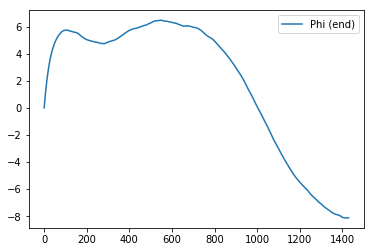

In [7]:
plt.plot((pla.phi),label = "Phi (end)");

plt.legend()

4.196938704e+17 4.288166064e+17


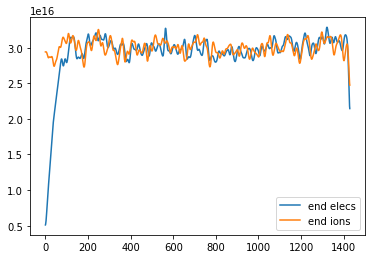

In [8]:
plt.plot(smooth(pla.ne),label = "end elecs");
plt.plot(smooth(pla.ni),label = "end ions");
plt.legend()
print(pla.ne.sum()*Lx,pla.ni.sum()*Lx)

~~~~~~ Initialisation of Plasma simulation ~~~~~~~~~~
time step dT = 3.00 10^-12 s, wpe = 32.36 10^-12 s
mesh step dX = 7.00 mu m, LDe = 74.34
 Let's go !!
The initialisation as been validated  !!


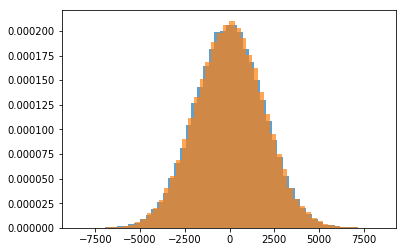

In [9]:
plt.hist(pla.ion.V[:,0],bins=50, alpha = 0.7,density=True);
plainit = plasma(dT,Nx,Lx,Npart,n,Te_0,Ti_0)
plt.hist(plainit.ion.V[:,0],bins=50, alpha = 0.7,density=True);



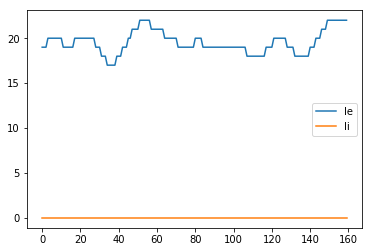

In [10]:
plt.plot(smooth(pla.history["Ie_c"][40:]), label = "Ie")
plt.plot(smooth(pla.history["Ii_c"][40:]), label = "Ii")
plt.legend()

In [11]:
nT = smooth((ne[:-1]*Te)[:-1])
plt.plot(phi)
plt.plot(Te)
plt.show()
plt.plot(ne*np.gradient(phi))
plt.plot(np.gradient(nT))


NameError: name 'ne' is not defined

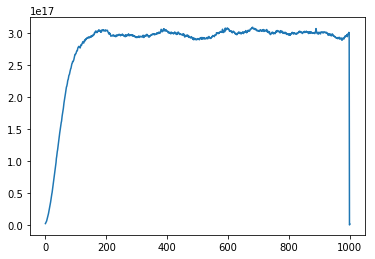

In [57]:
plt.plot(ne)

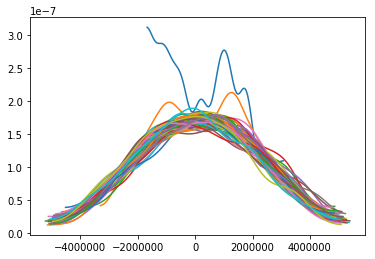

In [53]:
parts = pla.ele
Nc = 20
for i in np.arange(int(Nx/Nc)):
    j = Nc*i

    mask = (parts.x > pla.x_j[j]) & (parts.x < (pla.x_j[j]+Nc*pla.dx))
    V = parts.V[mask,0]
    hist, bin_edges = np.histogram(V, density= True, bins = 100)
    plt.plot(bin_edges[0:-1],smooth(hist))